In [7]:
import numpy as np
import os
import cv2

directory = 'CK+48'
dir_list = os.listdir(directory)
image_data_list = []
labels = []
emotions = []
l = 0

for data_dir in dir_list:
    # Check if the item is a directory
    if os.path.isdir(os.path.join(directory, data_dir)):
        data_list = os.listdir(os.path.join(directory, data_dir))
        for img in data_list:
            img_path = os.path.join(directory, data_dir, img)
            input_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            
            # Check if the image was loaded correctly
            if input_img is None:
                print(f"Warning: Skipping invalid or unreadable image at {img_path}")
                continue  # Skip this image if it cannot be loaded
            
            input_img = cv2.resize(input_img, (48, 48))  # Resize to (48, 48)
            input_img = np.expand_dims(input_img, axis=-1)  # Add channel dimension to get (48, 48, 1)
            image_data_list.append(input_img)
            labels.append(l)
        print('Loaded images from ' + data_dir)
        emotions.append(data_dir)
        l += 1

# Convert list to numpy array and normalize
img_data = np.array(image_data_list, dtype='float32') / 255.0
print("Shape of img_data:", img_data.shape)


Loaded images from happy
Loaded images from contempt
Loaded images from fear
Loaded images from surprise
Loaded images from sadness
Loaded images from anger
Loaded images from disgust
Shape of img_data: (981, 48, 48, 1)


In [8]:
print(emotions)
def getLabel(id):
    return emotions[id]


['happy', 'contempt', 'fear', 'surprise', 'sadness', 'anger', 'disgust']


In [9]:
processed_images = []
for img in image_data_list:
    # Assuming the images are single-channel (black and white)
    # Apply thresholding or edge detection before contouring
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank image to draw contours
    contour_img = np.zeros_like(img)
    
    # Draw contours on the blank image
    cv2.drawContours(contour_img, contours, -1, (255), 1)
    processed_images.append(contour_img)

# Convert to numpy array and reshape for model input
processed_images = np.array(processed_images).reshape(-1, 48, 48, 1) / 255.0


In [10]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
num_classes=7
Y = keras.utils.to_categorical(labels, num_classes)
X_train, X_test, y_train, y_test = train_test_split(processed_images, Y, test_size=0.2,shuffle=True)
X_train.shape


(784, 48, 48, 1)

[0. 0. 0. 0. 0. 0. 1.]


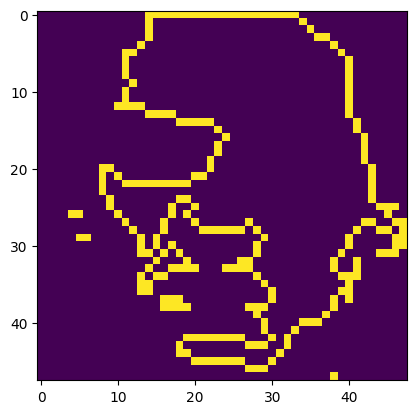

In [11]:
from matplotlib import pyplot as plt
print(y_train[499])
plt.imshow(X_train[499])
plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from keras.metrics import categorical_accuracy

model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(48,48,1),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Epoch 1/250
25/25 [==============================] - 12s 482ms/step - loss: 1.9308 - accuracy: 0.2309 - val_loss: 1.8899 - val_accuracy: 0.2030
Epoch 2/250
25/25 [==============================] - 12s 482ms/step - loss: 1.8846 - accuracy: 0.2423 - val_loss: 1.8446 - val_accuracy: 0.2030
Epoch 3/250
25/25 [==============================] - 11s 431ms/step - loss: 1.8818 - accuracy: 0.2500 - val_loss: 1.8711 - val_accuracy: 0.2030
Epoch 4/250
25/25 [==============================] - 10s 411ms/step - loss: 1.8728 - accuracy: 0.2487 - val_loss: 1.8476 - val_accuracy: 0.2030
Epoch 5/250
25/25 [==============================] - 12s 494ms/step - loss: 1.8466 - accuracy: 0.2538 - val_loss: 1.8308 - val_accuracy: 0.2030
Epoch 6/250
25/25 [==============================] - 13s 517ms/step - loss: 1.8020 - accuracy: 0.2730 - val_loss: 1.8130 - val_accuracy: 0.2132
Epoch 7/250
25/25 [==============================] - 10s 419ms/step - loss: 1.7532 - accuracy: 0.2768 - val_loss: 1.7305 - val_accuracy:

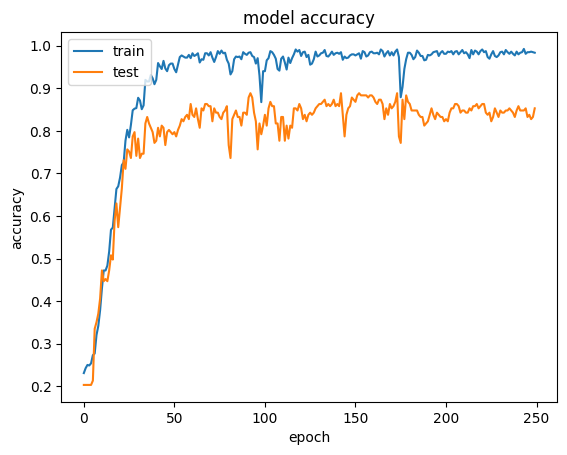

In [13]:
import matplotlib.pyplot as plt
history=model.fit(X_train, y_train,epochs=250,validation_data=(X_test, y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [14]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Training Accuracy: 0.9834
Final Validation Accuracy: 0.8528
